# denoising VAE for CIFAR10

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
from tensorboard import SummaryWriter
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
% matplotlib inline

## Set Hyperparameter

In [1]:
import sys
sys.path.append('../')

In [3]:
import dataloader

In [4]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

In [5]:
batch_size=32
learning_rate=0.0003
num_epoch=20
leak=0.05
drop_rate=0.02
z_dim=64

noise_level=0.1

In [74]:
traindset = dataloader.dset('../attack/train/*',transform=transform_test)
testdset = dataloader.dset('../attack/test/*',transform=transform_test,train=False)

Files already downloaded and verified
Files already downloaded and verified


In [75]:
# image, attacked, label
train_loader = dataloader.loader(traindset,batch_size=batch_size, shuffle=False, num_workers=4,drop_last=True)
test_loader = dataloader.loader(testdset,batch_size=batch_size, shuffle=False, num_workers=4,drop_last=True)

In [8]:
for i in enumerate(test_loader):
    break

In [10]:
i[1][0]


(0 ,0 ,.,.) = 
  0.6338  0.6531  0.7694  ...   0.2267  0.0134 -0.1804
  0.5174  0.4981  0.6531  ...   0.2073 -0.0060 -0.1223
  0.4981  0.4981  0.6338  ...   0.2654  0.0910 -0.1029
           ...             ⋱             ...          
 -1.1109 -1.6149 -1.8281  ...  -1.6924 -2.1771 -1.6537
 -1.2466 -1.4792 -1.7506  ...  -1.9251 -1.8669 -2.0414
 -1.3823 -1.3435 -1.5567  ...  -1.9638 -1.7700 -2.0220

(0 ,1 ,.,.) = 
 -0.2156 -0.2352 -0.1369  ...  -0.5499 -0.6286 -0.7466
 -0.2156 -0.2549 -0.1762  ...  -0.5499 -0.6286 -0.6876
 -0.2549 -0.2746 -0.2352  ...  -0.4909 -0.5499 -0.6679
           ...             ⋱             ...          
  0.0204 -0.4516 -0.6876  ...  -0.5106 -1.1596 -0.7466
 -0.1369 -0.4122 -0.7466  ...  -0.8056 -0.8056 -1.1596
 -0.3139 -0.3532 -0.6679  ...  -0.9039 -0.7662 -1.1006

(0 ,2 ,.,.) = 
 -1.2654 -1.3044 -1.2264  ...  -1.5190 -1.5190 -1.5776
 -1.2264 -1.4410 -1.3434  ...  -1.6166 -1.5971 -1.5580
 -1.3044 -1.5776 -1.5190  ...  -1.5580 -1.5580 -1.5776
           ...   

In [11]:
i[1][1]


(0 ,0 ,.,.) = 
  0.9245  0.9245 -0.0253  ...  -0.4906 -0.6650  0.2267
  0.8082 -0.2580 -0.1223  ...  -0.5100 -0.6844  0.2654
  0.8082 -0.2580 -0.1416  ...  -0.4518 -0.6069  0.2848
           ...             ⋱             ...          
 -1.6149 -2.0414 -1.1690  ...  -1.0527 -1.4792 -2.0801
 -1.7312 -0.8783 -2.1577  ...  -1.2660 -2.2740 -1.3629
 -0.8007 -0.7620 -2.0026  ...  -1.2854 -2.1771 -1.3435

(0 ,1 ,.,.) = 
  0.1974  0.1974 -0.8056  ...  -0.0779 -1.2186 -1.3169
 -0.8646 -0.9039  0.2368  ...  -0.0779 -1.2186 -1.2579
  0.1778 -0.9236  0.1974  ...  -0.0189 -1.1399 -1.2579
           ...             ⋱             ...          
  0.4138  0.0008 -0.1959  ...  -0.0386 -0.5892 -1.3169
 -0.8056 -1.0219 -0.2549  ...  -0.2942 -1.3562 -0.5892
  0.1188  0.0794 -0.1762  ...  -0.3729 -1.3366 -1.6119

(0 ,2 ,.,.) = 
 -1.7336 -0.6996 -1.6946  ...  -0.8752 -0.8752 -1.9873
 -1.6946 -0.8167 -0.7386  ...  -0.9532 -0.9532 -0.9142
 -1.7531 -1.9873 -0.8752  ...  -1.9678 -0.9142 -1.9873
           ...   

## CIFAR10 dataset.
It has 10 classes: 

‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’,
‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. 

The images in CIFAR-10 are of
size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.

In [8]:
# The output of torchvision datasets are PILImage images of range [0, 1].
# We transform them to Tensors of normalized range [-1, 1]
# Transforms are common image transforms. They can be chained together using `Compose`

transform_config = transforms.Compose(
    [transforms.ToTensor(),
     #transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])
     transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])

In [47]:
# Download the data
cifar_train=dset.CIFAR10(root="../data/", train=True, transform=transforms.ToTensor(), target_transform=None, download=True)
cifar_test=dset.CIFAR10(root="../data/", train=False, transform=transforms.ToTensor(), target_transform=None, download=True)

Files already downloaded and verified
Files already downloaded and verified


In [49]:
# i[0] == index, i[1][1] = label, i[1][0] = data (FloatTensor)
real_train_loader=torch.utils.data.DataLoader(cifar_train,batch_size=batch_size, shuffle=False, num_workers=2,drop_last=True)
real_test_loader=torch.utils.data.DataLoader(cifar_test,batch_size=batch_size,shuffle=False,num_workers=2,drop_last=True)

In [37]:
 tmp = nn.LogSoftmax()

## Model


### Encoder
* Two outputs
    * z_mu
    * z_logvar

In [23]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder,self).__init__()
        
        # output size = (image_width - kernel_width)/stride +1
        
        # torch.nn.Conv2d(in_channels, out_channels, kernel_size,
        #                 stride=1, padding=0, dilation=1,
        #                 groups=1, bias=True)



        self.conv_layer = nn.Sequential(
                        nn.Conv2d(3,64,3,padding=1),
                        nn.BatchNorm2d(64),
                        nn.ReLU(),
                        nn.Dropout(p=drop_rate,inplace=True),
                        # batch_size*  32*32  *64 featuremaps
            
                        nn.Conv2d(64,128,3,padding=1), 
                        nn.BatchNorm2d(128),
                        nn.ReLU(),
                        nn.Dropout(p=drop_rate,inplace=True),
                        nn.MaxPool2d(2,2),
                        # batch_size*  16*16  *128 featuremaps
            
                        nn.Conv2d(128,256,3,padding=1),
                        nn.BatchNorm2d(256),
                        nn.ReLU(),
                        nn.Dropout(p=drop_rate,inplace=True),
                        nn.MaxPool2d(2,2),
                        # batch_size*  8*8  *256 featuremaps
            
            
                        nn.Conv2d(256,256,3,padding=1,stride=2), # ((8+1*2) - 3)/2 +1 = 4
                        nn.BatchNorm2d(256),
                        nn.ReLU(),
                        nn.Dropout(p=drop_rate,inplace=True),
                        # batch_size*  4*4  *256 featuremaps
                
                        nn.Conv2d(256,1024,4, padding=0),  # ((4 - 2)/1 +1 = 28
                        nn.BatchNorm2d(1024),
                        nn.ReLU()
                        # batch_size*  1*1  *1024 featuremaps
            
        )
        
        self.fc_layer = nn.Sequential(
                        nn.Linear(1*1*1024,512),
                        nn.LeakyReLU(leak),
                        nn.Dropout(p=drop_rate,inplace=True),
                        nn.Linear(512,128),
                        nn.LeakyReLU(leak)
        )
   
        # ===== Two output vectors generated by the Encoder =====
        
        # One for z_mu
        self.z_mu=nn.Sequential(
            nn.Linear(128,z_dim),
            nn.LeakyReLU(leak)
        )
        
        # Another for z_logvar
        self.z_logvar=nn.Sequential(
            nn.Linear(128,z_dim),
            nn.LeakyReLU(leak)
        )
        
        
    def forward(self,x):
        out=self.conv_layer(x)
        out=out.view(batch_size,-1)
        
        out=self.fc_layer(out)

        z_mu=self.z_mu(out)
        z_logvar=self.z_logvar(out)
        
        return z_mu,z_logvar

### Decoder
* input: sampled_z
* output: reconstructed image

In [22]:
# torch.nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride=1, padding=0, 
#   output_padding=0, groups=1, bias=True, dilation=1)

# H_out=(H_in−1)∗stride(4th) + kernel_size(3rd) − 2∗padding(5th) + output_padding

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder,self).__init__()
        
        self.fc_layer=nn.Sequential(
            nn.Linear(z_dim,128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(leak),
            nn.Dropout(p=drop_rate,inplace=True),
            
            nn.Linear(128,256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(leak),
            nn.Dropout(p=drop_rate,inplace=True),
            
            nn.Linear(256,1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(leak),
            nn.Dropout(p=drop_rate,inplace=True),
            
            nn.Linear(1024,512*2*2),
            nn.BatchNorm1d(512*2*2),
            nn.LeakyReLU(leak)
        )
        
        self.transConv_layer=nn.Sequential(
            
            nn.ConvTranspose2d(512,256,3,2,1,1), 
            nn.BatchNorm2d(256),
            nn.ReLU(),
            # 4*4
            
            nn.Upsample(scale_factor=2),
            nn.ConvTranspose2d(256,256,3,1,1,0),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            # 8*8
            
            nn.Upsample(scale_factor=2),
            nn.ConvTranspose2d(256,128,3,1,1,0),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            # 16*16
            
            nn.Upsample(scale_factor=2),
            nn.ConvTranspose2d(128,64,3,1,1,0),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            # 32*32
            
            nn.ConvTranspose2d(64,3,3,1,1,0),
            nn.BatchNorm2d(3),
            nn.Sigmoid()
            # 32*32
            
        )
    
    # decode the sampled_z
    def forward(self,sampled_z):

        out=self.fc_layer(sampled_z)
        out=out.view(batch_size,-1,2,2)
        out=self.transConv_layer(out)

        return out

In [27]:
## check GPU availability here bro
use_gpu = torch.cuda.is_available()

### the Model as a whole
* encoder & decoder
* sample z

In [24]:
class VAE(nn.Module):
    def __init__(self, encoder, decoder):
        super(VAE,self).__init__()
        
        self.encoder=encoder
        self.decoder=decoder
    
    def sample_z(self, z_mu,z_logvar):
        
        # sample epsilon ~ N(0, 1)
        
        epsilon=Variable(torch.randn(batch_size,z_dim),requires_grad=False)
        if use_gpu:
            epsilon = epsilon.cuda()
        else:
            pass
        
        # reparameterization trick
        sampled_z=z_mu+torch.mul(torch.exp(z_logvar),epsilon)
       
        return sampled_z
        
            
    def forward(self,x):
        # encode the latent variable from the image
        # sample z from the encoded result
        # decode the sampled z
        
        z_mu,z_logvar=self.encoder(x)
        
        self.z_mu=z_mu
        self.z_logvar=z_logvar

        sampled_z=self.sample_z(z_mu,z_logvar)

        result=self.decoder(sampled_z)
        
        return result

### Check GPU availibility

In [15]:
if use_gpu:
    model = VAE(Encoder(),Decoder()).cuda()
    print ('Use GPU')
else:
    model = VAE(Encoder(),Decoder())
    print ('Use CPU')

Use GPU


### Function for adding noise in the input

In [76]:
def add_noise(x,noise_level=1):
    
    noise=noise_level*init.normal(torch.FloatTensor(batch_size,3,32,32),0,0.1)
    
    noise=Variable(noise)
    
    if use_gpu:
        noise=noise.cuda()
    else:
        pass
        
    result=x+noise

    return result

## Loss function & Optimizer for dVAE

In [77]:
def loss_func(generated_image,x,z_mu,z_logvar):
    
    recon=nn.MSELoss(size_average=False)
    reconstruction_loss=recon(generated_image,x)
    # alias the KL-divergence term
    latent_loss=-0.5*torch.sum(1+z_logvar-z_mu**2-z_logvar.exp())
#    latent_loss = torch.sum(0.5 * (z_mu**2 + torch.exp(z_logvar) -z_logvar - 1))
    
    return reconstruction_loss+latent_loss

In [78]:
optimizer=optim.Adam(model.parameters(),lr=learning_rate)

In [25]:
model = torch.load('./model/dVAE.pkl')

## Training

In [80]:
writer=SummaryWriter('./logs/')

try:
    model = torch.load('./model/dVAE.pkl')
    print("\n================== Model Restored ==================\n")
except:
    print("\n============== No Model to be Restored ==============\n")
    pass

for i in range(40,40+num_epoch):
    for batch_idx,[image,_,_] in enumerate(train_loader):
        n_iter = (i*len(real_train_loader))+batch_idx
        
        if use_gpu:
            x=Variable(image).cuda()
        else:
            x=Variable(image)
        # x: batchsize x 3 x 32 x 32
        
        optimizer.zero_grad()
        
        # add noise to the input
        noise_added_image = add_noise(x,noise_level)
        
        # reconstructed based on the noise added image
        reconstructed_image=model(noise_added_image)
#        reconstructed_image=model(x)        
        # calculate reconstruction loss with the original clean image
        loss=loss_func(reconstructed_image,x,model.z_mu,model.z_logvar)
        loss.backward()
        
        optimizer.step()
        
        if batch_idx%50==0:
            print('[Training Epoch: {} \tn_iter: {} \tLoss: {:.6f}]'.format(
                i+1, n_iter, loss.data[0]))
            plt.imshow(reconstructed_image.cpu().data[0].numpy().transpose(1,2,0), cmap='hsv')
            plt.show(block=True)
            
            
        if batch_idx%200==0:
            torch.save(model,'./model/dVAE_'+str(batch_idx)+'.pkl')
            torch.save(model,'./model/dVAE.pkl')
            
        writer.add_scalar('loss',loss.data[0] / len(x),n_iter)
  


================== Model Restored ==================



/home/voithru/anaconda3/envs/torch/lib/python3.6/site-packages/torch/serialization.py:147: UserWarning: Couldn't retrieve source code for container of type VAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/voithru/anaconda3/envs/torch/lib/python3.6/site-packages/torch/serialization.py:147: UserWarning: Couldn't retrieve source code for container of type Encoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/voithru/anaconda3/envs/torch/lib/python3.6/site-packages/torch/serialization.py:147: UserWarning: Couldn't retrieve source code for container of type Decoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
Process Process-63:
  File "/home/voithru/anaconda3/envs/torch/lib/python3.6/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
Process Process-64:
Process Proces

KeyboardInterrupt: 


================== Model Restored ==================

[Training Epoch: 61 	n_iter: 93720 	Loss: 151461.718750]


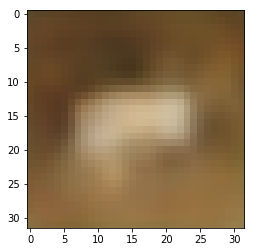

/home/voithru/anaconda3/envs/torch/lib/python3.6/site-packages/torch/serialization.py:147: UserWarning: Couldn't retrieve source code for container of type VAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/voithru/anaconda3/envs/torch/lib/python3.6/site-packages/torch/serialization.py:147: UserWarning: Couldn't retrieve source code for container of type Encoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/voithru/anaconda3/envs/torch/lib/python3.6/site-packages/torch/serialization.py:147: UserWarning: Couldn't retrieve source code for container of type Decoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


[Training Epoch: 61 	n_iter: 93770 	Loss: 130894.804688]


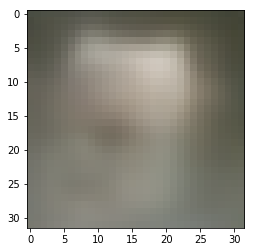

[Training Epoch: 61 	n_iter: 93820 	Loss: 146367.562500]


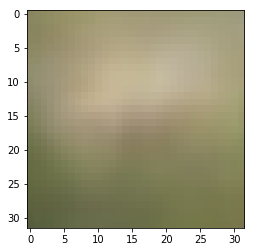

[Training Epoch: 61 	n_iter: 93870 	Loss: 139007.312500]


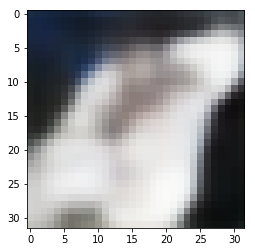

[Training Epoch: 61 	n_iter: 93920 	Loss: 153052.000000]


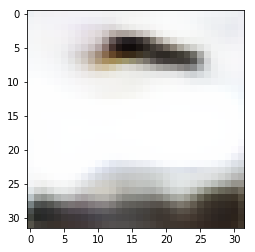

[Training Epoch: 61 	n_iter: 93970 	Loss: 134703.421875]


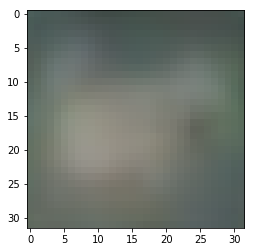

[Training Epoch: 61 	n_iter: 94020 	Loss: 118779.562500]


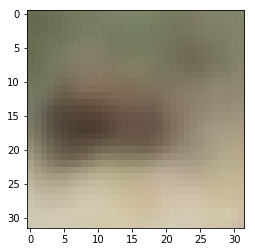

[Training Epoch: 61 	n_iter: 94070 	Loss: 130952.242188]


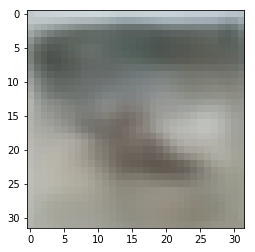

Process Process-68:
  File "/home/voithru/anaconda3/envs/torch/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Process Process-65:
Process Process-66:
Process Process-67:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/voithru/anaconda3/envs/torch/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
Traceback (most recent call last):


KeyboardInterrupt: 

  File "/home/voithru/anaconda3/envs/torch/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/voithru/anaconda3/envs/torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 34, in _worker_loop
    r = index_queue.get()
  File "/home/voithru/anaconda3/envs/torch/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/home/voithru/anaconda3/envs/torch/lib/python3.6/multiprocessing/queues.py", line 342, in get
    res = self._reader.recv_bytes()
  File "/home/voithru/anaconda3/envs/torch/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/home/voithru/anaconda3/envs/torch/lib/python3.6/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/home/voithru/anaconda3/envs/torch/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/h

In [81]:
writer=SummaryWriter('./logs/')

try:
#    model = torch.load('./model/dVAE.pkl')
    print("\n================== Model Restored ==================\n")
except:
    print("\n============== No Model to be Restored ==============\n")
    pass

for i in range(60,60+num_epoch):
    for batch_idx,[image,attacked,labels] in enumerate(train_loader):
        n_iter = (i*len(train_loader))+batch_idx
        
        if use_gpu:
            x=Variable(attacked).cuda()
        else:
            x=Variable(attacked)
        # x: batchsize x 3 x 32 x 32
        
        optimizer.zero_grad()
        
        # add noise to the input
        noise_added_image = add_noise(x,noise_level)
        
        # reconstructed based on the noise added image
        reconstructed_image=model(noise_added_image)
#        reconstructed_image=model(x)        
        # calculate reconstruction loss with the original clean image
        loss=loss_func(reconstructed_image,Variable(image).cuda(),model.z_mu,model.z_logvar)
        loss.backward()
        
        optimizer.step()
        
        if batch_idx%50==0:
            print('[Training Epoch: {} \tn_iter: {} \tLoss: {:.6f}]'.format(
                i+1, n_iter, loss.data[0]))
            plt.imshow(reconstructed_image.cpu().data[0].numpy().transpose(1,2,0), cmap='hsv')
            plt.show(block=True)
            correct = 0
            total = 0
            
        if batch_idx%200==0:
            torch.save(model,'./model/dVAE_'+str(batch_idx)+'.pkl')
            torch.save(model,'./model/dVAE.pkl')
            
        writer.add_scalar('loss',loss.data[0] / len(x),n_iter)


torch.Size([32, 3, 32, 32])

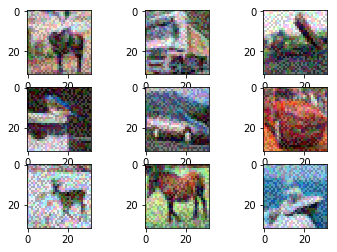

In [72]:
f, axarr = plt.subplots(3,3)
axarr[0,0].imshow(traindset[11][1].numpy().transpose(1,2,0))
axarr[0,1].imshow(traindset[1][1].numpy().transpose(1,2,0))
axarr[0,2].imshow(traindset[2][1].numpy().transpose(1,2,0))
axarr[1,0].imshow(traindset[13][1].numpy().transpose(1,2,0))
axarr[1,1].imshow(traindset[4][1].numpy().transpose(1,2,0))
axarr[1,2].imshow(traindset[5][1].numpy().transpose(1,2,0))
axarr[2,0].imshow(traindset[20][1].numpy().transpose(1,2,0))
axarr[2,1].imshow(traindset[7][1].numpy().transpose(1,2,0))
axarr[2,2].imshow(traindset[8][1].numpy().transpose(1,2,0))

In [47]:
for i in train_loader:
    break

In [48]:
testdset

In [49]:
inp = Variable(i[1]).cuda()

In [50]:
outp = model(inp)

In [51]:
outp[0].data.cpu()


(0 ,.,.) = 
  0.3503  0.3544  0.3677  ...   0.3780  0.3738  0.3678
  0.3698  0.3870  0.3936  ...   0.3911  0.3881  0.3730
  0.3868  0.3994  0.4083  ...   0.4137  0.4035  0.3855
           ...             ⋱             ...          
  0.5378  0.5553  0.5578  ...   0.5236  0.5199  0.5111
  0.5491  0.5521  0.5495  ...   0.5264  0.5276  0.5151
  0.5423  0.5472  0.5470  ...   0.5270  0.5302  0.5164

(1 ,.,.) = 
  0.2996  0.2896  0.2923  ...   0.2723  0.2684  0.2852
  0.2936  0.2985  0.3014  ...   0.2747  0.2627  0.2681
  0.2945  0.2966  0.3008  ...   0.2811  0.2651  0.2682
           ...             ⋱             ...          
  0.4158  0.4168  0.4061  ...   0.4055  0.4158  0.4270
  0.4346  0.4238  0.4069  ...   0.4150  0.4249  0.4387
  0.4398  0.4275  0.4150  ...   0.4322  0.4420  0.4520

(2 ,.,.) = 
  0.1918  0.1721  0.1699  ...   0.1384  0.1421  0.1665
  0.1719  0.1699  0.1741  ...   0.1366  0.1334  0.1417
  0.1732  0.1720  0.1770  ...   0.1412  0.1362  0.1401
           ...            

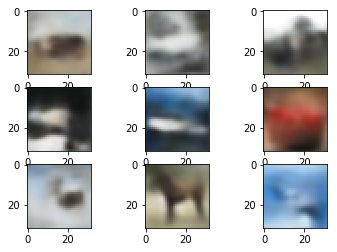

In [71]:
f, axarr = plt.subplots(3,3)
axarr[0,0].imshow(outp[11].data.cpu().numpy().transpose(1,2,0))
axarr[0,1].imshow(outp[1].data.cpu().numpy().transpose(1,2,0))
axarr[0,2].imshow(outp[2].data.cpu().numpy().transpose(1,2,0))
axarr[1,0].imshow(outp[13].data.cpu().numpy().transpose(1,2,0))
axarr[1,1].imshow(outp[4].data.cpu().numpy().transpose(1,2,0))
axarr[1,2].imshow(outp[5].data.cpu().numpy().transpose(1,2,0))
axarr[2,0].imshow(outp[20].data.cpu().numpy().transpose(1,2,0))
axarr[2,1].imshow(outp[7].data.cpu().numpy().transpose(1,2,0))
axarr[2,2].imshow(outp[8].data.cpu().numpy().transpose(1,2,0))

In [205]:
correct = 0
total = 0
for data in test_loader:
    images,attack, labels = data
    outputs = net(Variable(attack).cuda())
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted.cuda() == labels.cuda()).sum()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

AttributeError: 'list' object has no attribute 'size'

In [203]:
images


(0 ,0 ,.,.) = 
  0.3294  0.3020  0.2627  ...   0.2667  0.2392  0.2275
  0.2941  0.2745  0.2863  ...   0.2000  0.1961  0.2157
  0.2941  0.2549  0.2549  ...   0.2549  0.2235  0.2275
           ...             ⋱             ...          
  0.3412  0.2706  0.2353  ...   0.4588  0.4667  0.3765
  0.3490  0.3333  0.2471  ...   0.3843  0.3529  0.2627
  0.3176  0.3412  0.3608  ...   0.2902  0.2588  0.2275

(0 ,1 ,.,.) = 
  0.3098  0.3333  0.3294  ...   0.2824  0.2471  0.2275
  0.3333  0.3569  0.3843  ...   0.2118  0.2157  0.2392
  0.3647  0.3529  0.3529  ...   0.3098  0.2706  0.2588
           ...             ⋱             ...          
  0.3686  0.2863  0.2588  ...   0.5216  0.5294  0.4353
  0.3843  0.3725  0.2902  ...   0.4353  0.4275  0.3333
  0.3608  0.4000  0.4196  ...   0.3176  0.3176  0.2863

(0 ,2 ,.,.) = 
  0.3098  0.2980  0.1804  ...   0.4941  0.3608  0.2196
  0.2392  0.2314  0.2078  ...   0.3882  0.2314  0.1294
  0.2039  0.1686  0.1804  ...   0.1725  0.1373  0.1412
           ...   

In [204]:
attack

Variable containing:
(0 ,0 ,.,.) = 
 -0.6912 -0.8075 -1.9900  ...  -1.9706 -2.0869 -2.1451
 -1.8737 -0.9238 -0.8657  ...  -1.2340 -1.2340 -1.1564
 -0.8463 -1.0014 -1.0014  ...  -1.0014 -1.1371 -1.1177
           ...             ⋱             ...          
 -0.6524 -0.9432 -1.0789  ...  -0.1678 -0.1290 -0.4974
 -0.6137 -0.6718 -1.0401  ...  -0.4780 -0.5943 -1.9900
 -1.7768 -0.6524 -0.5749  ...  -1.8737 -2.0094 -2.1451

(0 ,1 ,.,.) = 
 -1.7690 -1.6706 -1.6903  ...  -1.8870 -2.0246 -2.1230
 -1.6706 -1.5723 -0.4316  ...  -1.1396 -1.1200 -2.0640
 -0.5103 -1.5920 -1.5920  ...  -1.7690 -1.9263 -1.9853
           ...             ⋱             ...          
 -0.4906 -1.8673 -1.9853  ...   0.1387 -0.8643 -1.2576
 -1.4740 -1.5133 -0.8250  ...  -1.2576 -0.2546 -1.6706
 -1.5723 -0.3530 -0.2743  ...  -1.7493 -0.7070 -0.8250

(0 ,2 ,.,.) = 
 -0.5472 -0.6057 -2.1080  ...  -0.8203 -1.3861 -1.9519
 -1.8739 -1.9129 -0.9764  ...  -1.2690 -1.9129 -2.3226
 -0.9959 -2.1665 -2.1080  ...  -2.1470 -1.2690 -1.24

In [195]:
testdset[4][1]


(0 ,.,.) = 
 -0.2580 -0.1610 -0.5487  ...  -1.6343 -1.5955 -0.2192
 -0.1804 -0.0060 -1.4792  ...  -1.5955 -1.4017 -1.4598
 -1.2466  0.0910 -1.2660  ...  -1.1690 -1.2466 -0.5487
           ...             ⋱             ...          
  0.2848  0.2073 -0.3936  ...   0.0134  0.4787 -0.3743
  0.2654 -1.2078 -0.8395  ...   1.1378  0.1879 -0.6650
 -0.0253 -1.9251 -2.1189  ...   1.1378  1.3316  0.8664

(1 ,.,.) = 
 -1.3169 -1.0809 -0.2352  ...  -1.3366 -1.1596  0.1974
 -1.1006 -0.7072 -0.0386  ...  -0.1959  0.2368 -1.0809
 -0.8252  0.5908  0.1974  ...   0.3941  0.3941 -0.3139
           ...             ⋱             ...          
 -0.2549 -0.3139  0.0401  ...   1.7314  2.2625  1.2004
 -0.2746 -0.6679 -0.4516  ...   1.8888  0.8661 -0.2156
 -0.7072 -1.6119 -0.6679  ...   0.6891  0.8071  0.2761

(2 ,.,.) = 
 -1.4410 -1.2069 -0.3679  ...  -1.6166 -0.2509 -0.0167
 -0.1533 -0.8947 -1.3239  ...  -0.4069  0.0418 -1.1678
 -1.0508  0.3735 -1.0898  ...   0.1589  0.1784 -1.4215
           ...            

In [ ]:
# 이제 pretrained 불러오기

In [13]:
from models import *

In [14]:
net = VGG('VGG19')

In [15]:
net = net.cuda()

In [16]:
checkpoint = torch.load('./checkpoint/ckpt.t7')

In [17]:
net = checkpoint['net']

In [ ]:
norm = transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))

In [44]:
criterion = nn.CrossEntropyLoss()
test_loss = 0
correct = 0
total = 0
for batch_idx, (inputs, attack,targets) in enumerate(train_loader):
    inputs, attack, targets = Variable(torch.FloatTensor(inputs), volatile=True),Variable(torch.FloatTensor(attack)), Variable(torch.LongTensor(targets))
    if 1:
        inputs, attack, targets = inputs.cuda(), attack.cuda(),targets.cuda()
#    for i in range(attack.size()[0]):
#        attaattack = transform_test(attack.cpu().data.numpy()[0])
    attack = model(attack)
#    attack = norm(attack)
    outputs = net(attack)
    loss = criterion(outputs.cpu(), targets.cpu())

    test_loss += loss.data[0]
    _, predicted = torch.max(outputs.data, 1)
    total += targets.size(0)
    correct += predicted.eq(targets.data).cpu().sum()

In [43]:
correct/total

0.1662932138284251

In [45]:
correct/total

0.13420294494238155

In [30]:
attack

Variable containing:
(0 ,0 ,.,.) = 
  2.6774e-01  2.5881e-01  2.6077e-01  ...   2.4203e-01  2.4598e-01  2.5856e-01
  2.5686e-01  2.6103e-01  2.5850e-01  ...   2.5386e-01  2.5401e-01  2.5187e-01
  2.5643e-01  2.5312e-01  2.5126e-01  ...   2.5714e-01  2.5180e-01  2.5274e-01
                 ...                   ⋱                   ...                
  4.2695e-01  4.4246e-01  4.5388e-01  ...   4.7842e-01  4.6101e-01  4.5355e-01
  4.3157e-01  4.4461e-01  4.5638e-01  ...   4.8908e-01  4.7395e-01  4.6187e-01
  4.3946e-01  4.4941e-01  4.5870e-01  ...   4.9291e-01  4.8531e-01  4.7220e-01

(0 ,1 ,.,.) = 
  2.7833e-01  2.7074e-01  2.7014e-01  ...   2.4684e-01  2.4834e-01  2.6243e-01
  2.6183e-01  2.6464e-01  2.5886e-01  ...   2.5168e-01  2.5259e-01  2.5463e-01
  2.5970e-01  2.5844e-01  2.5157e-01  ...   2.5081e-01  2.4968e-01  2.5482e-01
                 ...                   ⋱                   ...                
  4.0906e-01  4.1718e-01  4.3355e-01  ...   4.6500e-01  4.4878e-01  4.3467e-01


In [31]:
torchvision.N

In [227]:
transform_test(attack.cpu().data.numpy()[0])


(0 ,.,.) = 
 -2.4245 -2.4247 -2.4247  ...  -2.4218 -2.4218 -2.4217
 -2.4244 -2.4246 -2.4247  ...  -2.4223 -2.4222 -2.4221
 -2.4251 -2.4254 -2.4254  ...  -2.4234 -2.4235 -2.4234

(1 ,.,.) = 
 -2.4138 -2.4136 -2.4138  ...  -2.4106 -2.4106 -2.4106
 -2.4136 -2.4136 -2.4137  ...  -2.4112 -2.4111 -2.4112
 -2.4143 -2.4143 -2.4145  ...  -2.4123 -2.4124 -2.4125

(2 ,.,.) = 
 -2.2168 -2.2167 -2.2169  ...  -2.2136 -2.2137 -2.2137
 -2.2166 -2.2167 -2.2169  ...  -2.2143 -2.2143 -2.2143
 -2.2173 -2.2174 -2.2176  ...  -2.2154 -2.2155 -2.2156
...

(29,.,.) = 
  0.0009  0.0009  0.0009  ...   0.0016  0.0017  0.0017
  0.0009  0.0009  0.0009  ...   0.0015  0.0015  0.0015
  0.0007  0.0007  0.0007  ...   0.0012  0.0013  0.0013

(30,.,.) = 
  0.0009  0.0009  0.0009  ...   0.0016  0.0016  0.0016
  0.0009  0.0009  0.0009  ...   0.0015  0.0015  0.0015
  0.0007  0.0007  0.0007  ...   0.0012  0.0012  0.0012

(31,.,.) = 
  0.0010  0.0009  0.0009  ...   0.0015  0.0015  0.0015
  0.0010  0.0009  0.0009  ...   0.0014

In [223]:
tmp = attack.cpu().data.numpy()

In [226]:
tmp.shape[0]

(32, 3, 32, 32)

In [213]:
attack

Variable containing:
(0 ,0 ,.,.) = 
  2.3559e-01  2.2816e-01  2.3635e-01  ...   2.2247e-01  2.3076e-01  2.4623e-01
  2.2672e-01  2.3469e-01  2.3854e-01  ...   2.2886e-01  2.3508e-01  2.3665e-01
  2.2661e-01  2.2550e-01  2.3090e-01  ...   2.2580e-01  2.2647e-01  2.3317e-01
                 ...                   ⋱                   ...                
  3.7405e-01  3.9104e-01  3.9887e-01  ...   4.1860e-01  4.0028e-01  3.8288e-01
  3.7673e-01  3.9085e-01  3.9657e-01  ...   4.2572e-01  4.0727e-01  3.8705e-01
  3.8110e-01  3.8745e-01  3.9478e-01  ...   4.2582e-01  4.0989e-01  3.9522e-01

(0 ,1 ,.,.) = 
  2.4211e-01  2.3756e-01  2.4342e-01  ...   2.2280e-01  2.2781e-01  2.4330e-01
  2.2825e-01  2.3700e-01  2.3897e-01  ...   2.2496e-01  2.2893e-01  2.3169e-01
  2.2761e-01  2.3125e-01  2.3248e-01  ...   2.1950e-01  2.2181e-01  2.2769e-01
                 ...                   ⋱                   ...                
  3.4886e-01  3.5930e-01  3.6361e-01  ...   3.8339e-01  3.7205e-01  3.5376e-01


In [ ]:
torch.norm

In [185]:
norm(attack.cpu())

RuntimeError: in-place operations can be only used on variables that don't share storage with any other variables, but detected that there are 2 objects sharing it

In [56]:
for i in real_train_loader:
    break

In [59]:
i[0]


(0 ,0 ,.,.) = 
  0.2314  0.1686  0.1961  ...   0.6196  0.5961  0.5804
  0.0627  0.0000  0.0706  ...   0.4824  0.4667  0.4784
  0.0980  0.0627  0.1922  ...   0.4627  0.4706  0.4275
           ...             ⋱             ...          
  0.8157  0.7882  0.7765  ...   0.6275  0.2196  0.2078
  0.7059  0.6784  0.7294  ...   0.7216  0.3804  0.3255
  0.6941  0.6588  0.7020  ...   0.8471  0.5922  0.4824

(0 ,1 ,.,.) = 
  0.2431  0.1804  0.1882  ...   0.5176  0.4902  0.4863
  0.0784  0.0000  0.0314  ...   0.3451  0.3255  0.3412
  0.0941  0.0275  0.1059  ...   0.3294  0.3294  0.2863
           ...             ⋱             ...          
  0.6667  0.6000  0.6314  ...   0.5216  0.1216  0.1333
  0.5451  0.4824  0.5647  ...   0.5804  0.2431  0.2078
  0.5647  0.5059  0.5569  ...   0.7216  0.4627  0.3608

(0 ,2 ,.,.) = 
  0.2471  0.1765  0.1686  ...   0.4235  0.4000  0.4039
  0.0784  0.0000  0.0000  ...   0.2157  0.1961  0.2235
  0.0824  0.0000  0.0314  ...   0.1961  0.1961  0.1647
           ...   

In [ ]:
reconstructed_image.cpu().data[0].numpy().transpose(1,2,0)

## Sample results

In [ ]:
example_z = Variable(torch.FloatTensor(8*8*z_dim).normal_(0,1).view(64,-1))

samples = model.decoder(example_z).data.numpy()
fig = plt.figure(figsize=(10, 10))
gs = gridspec.GridSpec(8, 8)
gs.update(wspace=0.05, hspace=0.05)
for i, sample in enumerate(samples):
    ax = plt.subplot(gs[i])
    plt.axis('off')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_aspect('equal')
    plt.imshow(sample.reshape(32, 32,3).transpose(1,2,0), cmap='hsv')
fig.savefig("generated_images_by_{}epochs.png".format(num_epoch))